# 이미지 분류기 학습하기
지금까지 신경망을 정의하는 방법과 신경망 내의 손실 계산 및 가중치를 갱시하는 방법에 대해 학습하였다. 이제 학습할 데이터를 어떻게 다루는지 학습하려고 한다.

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를 이용하여 NumPy 배열로 불러오면 된다. 그 후 그 배열을 torch.*Tensor 로 변환한다.
이미지는 Pillow나 OpenCV 같은 패키지가 유용하고, 오디오를 처리할 때는 SciPy와 LibROSA가 유용하다. 텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도 유용하다.

특별히 영상 분야를 위한 **torchvision** 이라는 패키지가 만들어져 있는데, 여기에는 Imagenet이나 CIFAR-10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 데이터 로더(data loader), 즉 torchvision.datasets 과 이미지용 데이터 변환기 (data transformer), 즉 torch.utils.data.DataLoader 가 포함되어 있다. 

여기서는 CIFAR-10 데이터셋을 사용할 것이다. CIFAR-10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상로 이뤄져 있다는 것을 의미한다.

다음과 같은 단계로 학습한다.

1. torchvision 을 사용하여 CIFAR-10의 학습(training), 평가(test) 데이터셋을 로드하여 정규화(nomarlizing)한다.

2. 합성곱 신경망(Convolution Neural Network)을 정의한다.

3. 손실 함수를 정의한다.

4. 학습용 데이터를 사용하여 신경망을 학습시킨다.

5. 시험용 데이터를 사용하여 신경망을 검사한다.


###  1. CIFAR-10 로딩 및정규화
torchvision 을 사용하여 매우 쉽게 CIFAR-10을 로드할 수 있다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지이다. 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환한다.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


예시로 학습용 이미지 몇 가지 보기

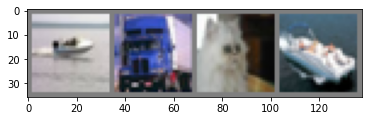

 ship truck   cat  ship


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 합성곱 신경망(Convolution Neural Network) 정의하기
이전의 신경망 학습 자료에서 신경망을 복사한 후, (기존에 1채널 이미지만 처리하도록 정의된 것을) 3채널 이미지를 처리할 수 있도록 수정한다.

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # First 2D convolutional layer, taking in 3 input channels (image)
        # 6 output channels, a square kernel size of 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Max pooling over a (2, 2) mask
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second 2D convolutional layer, taking in 6 input layers,
        # 16 output channels, a square kernel size of 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        # Use the rectified-linear activation function over x
        # Run max pooling over x
        x = self.pool(F.relu(self.conv1(x)))
        
        # Pass data through conv1
        # Use the rectified-linear activation function over x
        # Run max pooling over x
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. 손실 함수와 Optimizer 정의하기
손실함수는 Cross-Entropy loss 를 사용하고, optimizer는 모멘텀(momentum) 값을 갖는 SGD를 사용한다.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 신경망 학습하기
단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면 된다.

In [7]:
for epoch in range(3):   # 데이터셋을 수차례 반복

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.261
[1,  4000] loss: 1.235
[1,  6000] loss: 1.251
[1,  8000] loss: 1.224
[1, 10000] loss: 1.208
[1, 12000] loss: 1.211
[2,  2000] loss: 1.128
[2,  4000] loss: 1.140
[2,  6000] loss: 1.124
[2,  8000] loss: 1.138
[2, 10000] loss: 1.164
[2, 12000] loss: 1.141
[3,  2000] loss: 1.062
[3,  4000] loss: 1.056
[3,  6000] loss: 1.072
[3,  8000] loss: 1.057
[3, 10000] loss: 1.091
[3, 12000] loss: 1.080
Finished Training


### 5. 시험용 데이터로 신경망 검사하기
지금까지 학습용 데이터셋을 총 3회 반복하며 신경망을 학습시켰다. 코드 첫 줄의 'for epoch in range(3):'에서 3이 0부터 2까지 총 3번 반복함을 의미하는 것이다. 신경망이 실제로 2번의 반복동안 무엇을 배웠는지 테스트를 하겠다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인한다. 만약 예측이 맞다면 샘플을 correct predictions 목록에 추가한다.

첫번째로 테스트셋의 이미지와 진짜 정답을 출력한다.

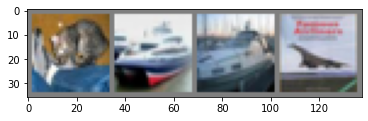

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

이제 위 예시 이미지들을 신경망이 어떻게 예측했는지를 아래의 코드로 살펴본다.

In [9]:
outputs = net(images)

출력은 총 10개의 클래스 각각에 대한 값으로 나타난다. 어떤 클래스에 대해서 더 높은 값이 나타난다는 것은, 신경망이 그 이미지가 해당 클래스에 더 가깝다고 생각한다는 것이다. 따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑으면 다음과 같다.

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  ship plane


4개의 이미지 중 3개의 이미지에 대한 분류는 정확하며 1개의 이미지에 대한 분류는 틀렸다. 간단하게 해본 것 치곤 괜찮은 결과이다.

전체 데이터셋에 대한 신경망의 학습 정확도는 다음과 같다.

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


정확도가 총 10개의 클래스 중 한 개를 선택하는 10% 보다는 높게 나왔다. 신경망이 무언가 학습했다고 판단할 수 있다.

그렇다면 학습이 잘 된 클래스와 잘 되지 않은 클래스를 아래의 코드로 알아보자.

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 51 %
Accuracy of  bird : 47 %
Accuracy of   cat : 37 %
Accuracy of  deer : 54 %
Accuracy of   dog : 49 %
Accuracy of  frog : 69 %
Accuracy of horse : 66 %
Accuracy of  ship : 78 %
Accuracy of truck : 70 %


신경망 내에서 cat 클래스가 유독 학습이 잘 안되었다는 것을 알 수 있고, ship 클래스가 학습이 아주 잘 되었다는 것을 알 수 있다.

----------------------------------------------------------------------------------